# Cluster the data and visualize
Following [this guide](https://www.askpython.com/python/examples/plot-k-means-clusters-python)

In [1]:
!pip install scikit-learn matplotlib mplcursors ipympl

Defaulting to user installation because normal site-packages is not writeable


In [2]:
#Importing required modules
from typing import List, Tuple
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import json
import cluster

file_path = f"data_store/embeddings_seed_69420_size_10000.json"
embeddings: List[Tuple[str, List[float]]] = json.load(open(file_path, "r"))

N_CLUSTERS = 10
N_DIMS = 4
df, label, u_labels = cluster.cluster(embeddings, n_clusters=N_CLUSTERS, dimensions=N_DIMS)

/home/lev/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [3]:
!pip install ipywidgets --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [7]:
np.random.seed(69_420)
choices = np.random.choice(np.arange(len(df)), size=200)

IndexError: index 6 is out of bounds for axis 0 with size 6

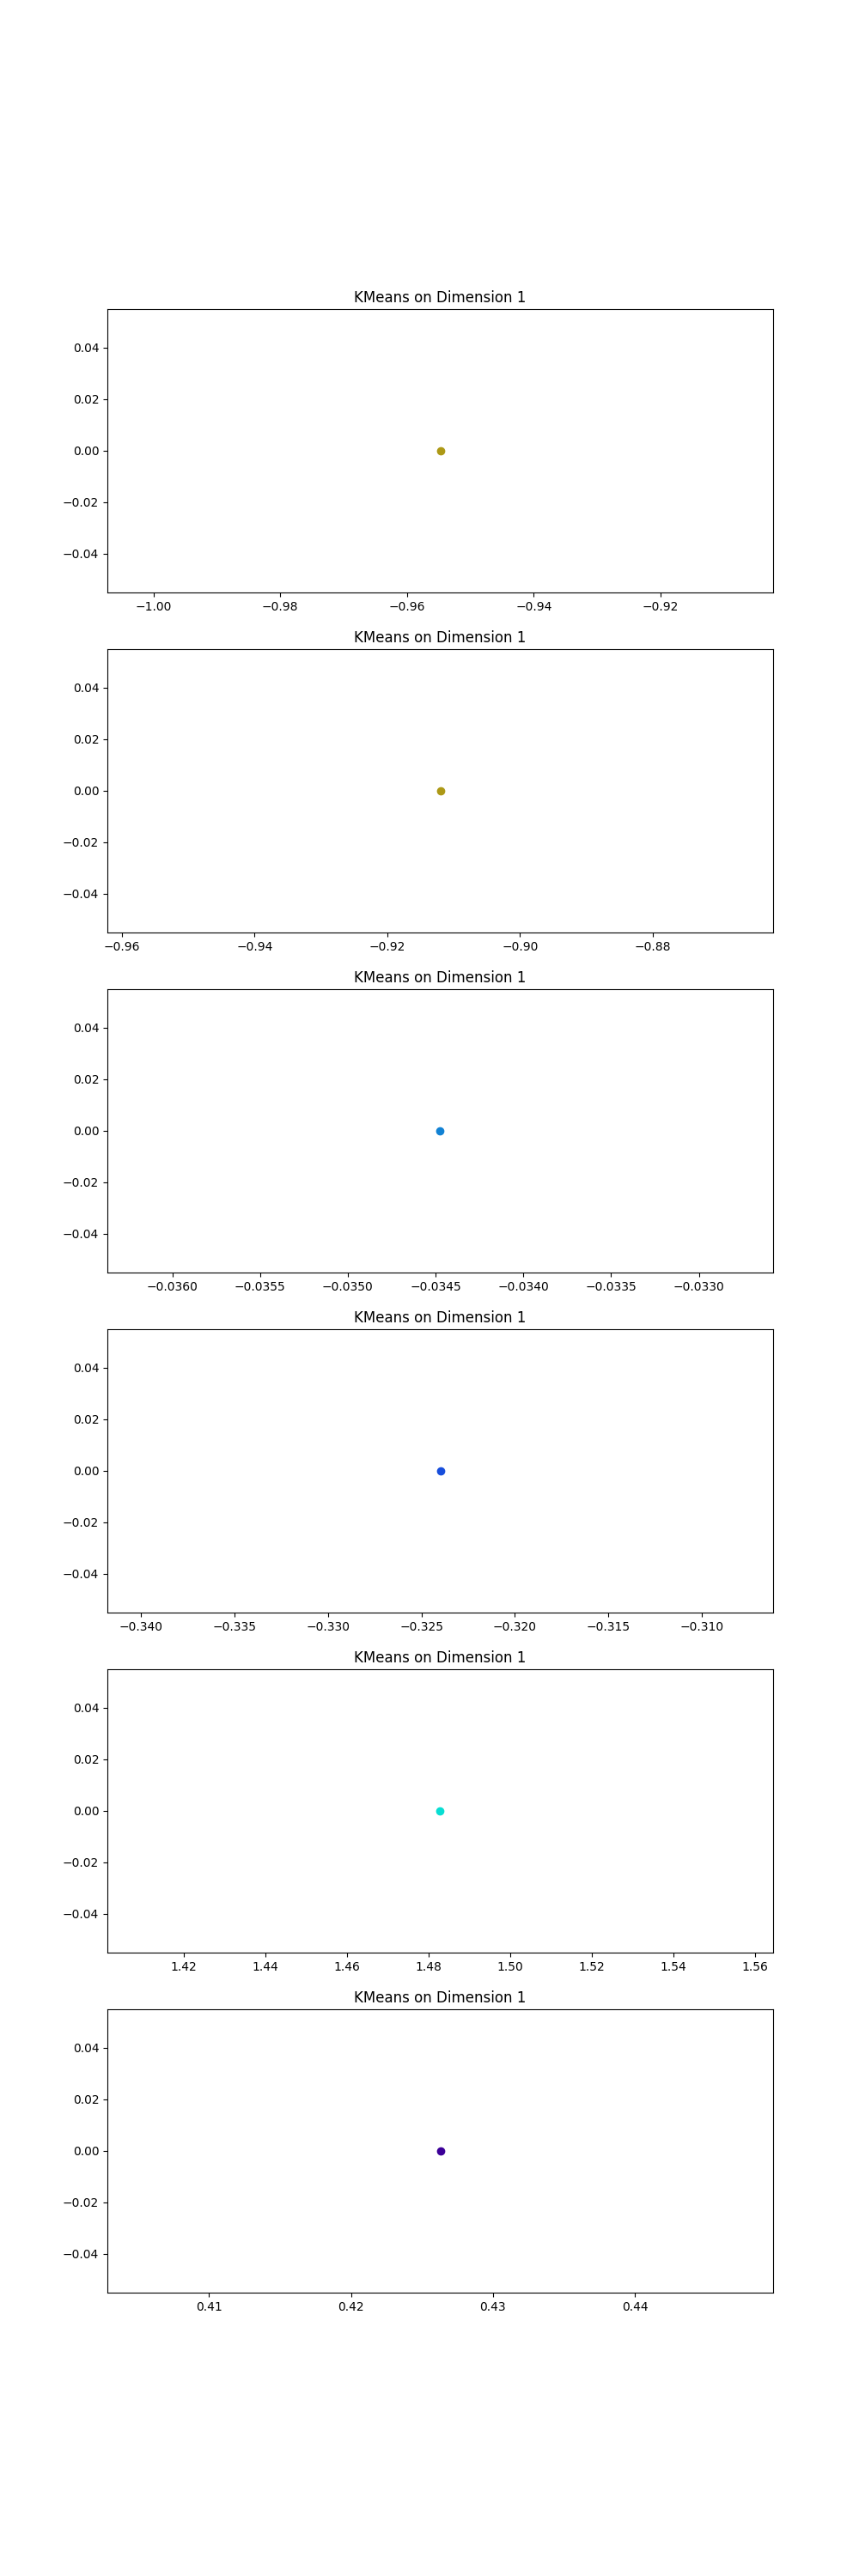

In [ ]:

# %matplotlib inline
%matplotlib ipympl

from mplcursors import cursor
import mplcursors
from matplotlib.text import Annotation

# fig, ax = plt.subplots()

# for i in range(len(df)):
# 		np.random.seed(label[i])
# 		ax.scatter(df[i , 0] , df[i , 1] , label = f"Cluster {i}", color = np.random.rand(3,))
colors = np.random.rand(N_CLUSTERS, 3)
scs = []
# for i in range (len(df[:100])):
fig, ax = plt.subplots(int(N_DIMS * (N_DIMS - 1) / 2), figsize=(10,30))

plot_idx = 0

for dim_1 in range(N_DIMS):
    # for dim_2 in range(dim_1):
    for i in choices:
        sc = ax[plot_idx].scatter(df[i, dim_1], 0, label=embeddings[i][0], color=colors[label[i]])
        ax[plot_idx].set_title(f"KMeans on Dimension {dim_1 + 1}")
        scs.append(sc)

        crs = mplcursors.cursor(ax[plot_idx], hover=True)
        # ax[plot_idx].figure(figsize=(10,6))
    plot_idx += 1

crs.connect("add", lambda sel: sel.annotation.set_text(sel.annotation._text))#embeddings[sel.index][0]))#, sel.target[0], sel.target[1])))
# plt.show()
# for l in label:
#     mask = label == l
#     sc = ax.scatter(df[mask, 0], df[mask, 1], label=f"Cluster {l}", color=np.random.rand(3,))
#     scs.append(sc)
def on_plot_hover(event):
    # Iterating over each data member plotted
    return 
    for curve in sc.get_lines():
        # Searching which data member corresponds to current mouse position
        if curve.contains(event)[0]:
            print("over %s" % curve.get_gid())
            
fig.canvas.mpl_connect('motion_notify_event', on_plot_hover)           
